# Аналіз жестів руки: k-NN та k-means

**Об'єкт дослідження:** гіпотетичне зображення руки  
**Ознаки:** висота та ширина долоні (2D простір)  
**Класи:** Кулак, Долоня

---
**Щоб запустити:** виконайте всі клітинки (Run All) або `jupyter nbconvert --to notebook --execute hand_gesture_analysis.ipynb`


In [9]:
import math
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from IPython.display import display, Image

class RNG:
    def __init__(self, seed=42):
        self.state = seed
    def random(self):
        self.state = (1103515245 * self.state + 12345) % (2**31)
        return self.state / (2**31)
    def gauss(self, mu, sigma):
        u1, u2 = self.random(), self.random()
        return mu + sigma * math.sqrt(-2 * math.log(u1 + 1e-10)) * math.cos(2 * math.pi * u2)

rng = RNG(42)
def generate_class(n, cw, ch, sw, sh):
    return [(rng.gauss(cw, sw), rng.gauss(ch, sh)) for _ in range(n)]

fist_data = generate_class(30, 8, 4, 0.8, 0.9)
palm_data = generate_class(30, 16, 16, 1.5, 1.8)
X = fist_data + palm_data
y = [0]*30 + [1]*30
fist_w = [p[0] for p in fist_data]
fist_h = [p[1] for p in fist_data]
palm_w = [p[0] for p in palm_data]
palm_h = [p[1] for p in palm_data]

rng_v = RNG(777)
victory_data = [(rng_v.gauss(10, 1.5), rng_v.gauss(12, 2.0)) for _ in range(30)]

print(f"Згенеровано {len(X)} зразків: {len(fist_data)} кулак, {len(palm_data)} долоня")
print("Приклади розмірів (w, h) см:")
print("Кулак:", fist_data[:3])
print("Долоня:", palm_data[:3])
print("Знак перемоги:", victory_data[:3])


Згенеровано 60 зразків: 30 кулак, 30 долоня
Приклади розмірів (w, h) см:
Кулак: [(7.174475578577263, 4.188038952899617), (9.026628251221172, 4.4291169855005625), (7.8266907106739945, 2.347990891586238)]
Долоня: [(15.622302161187871, 15.032222335933044), (15.245119104071913, 16.18741151627463), (16.18132862693942, 14.71884019778335)]
Знак перемоги: [(11.403649423521117, 9.084378378061952), (8.33442326184495, 10.390680727227998), (9.783761871549299, 12.998196259585868)]


## 1. Приклади обмежувальних рамок (3 жести)


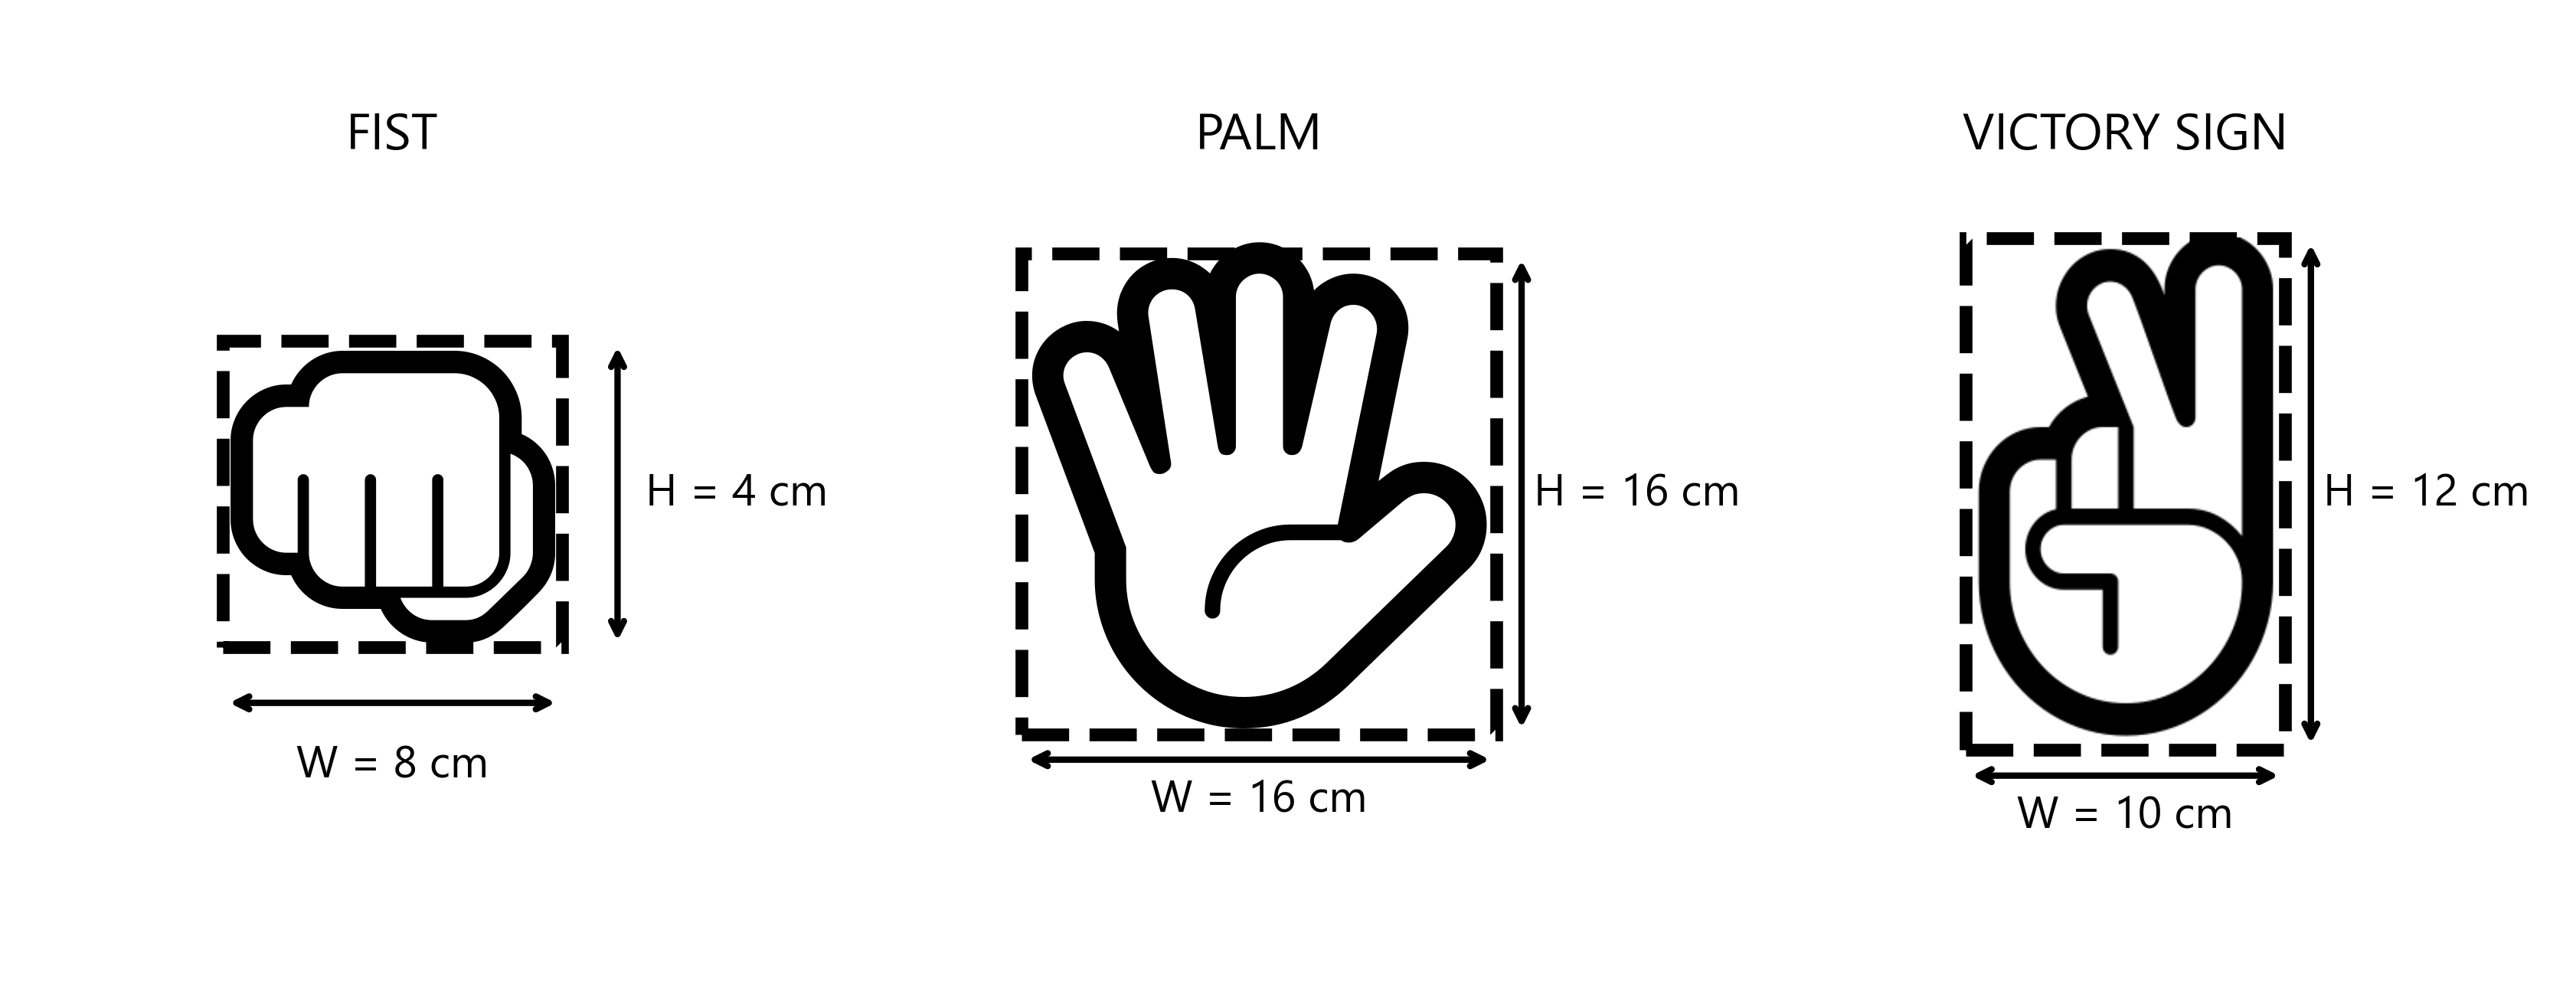

In [10]:
import subprocess
import sys
subprocess.run([sys.executable, "generate_box_examples.py"], check=True)
display(Image("box_examples.png"))


## 2. Візуалізація даних


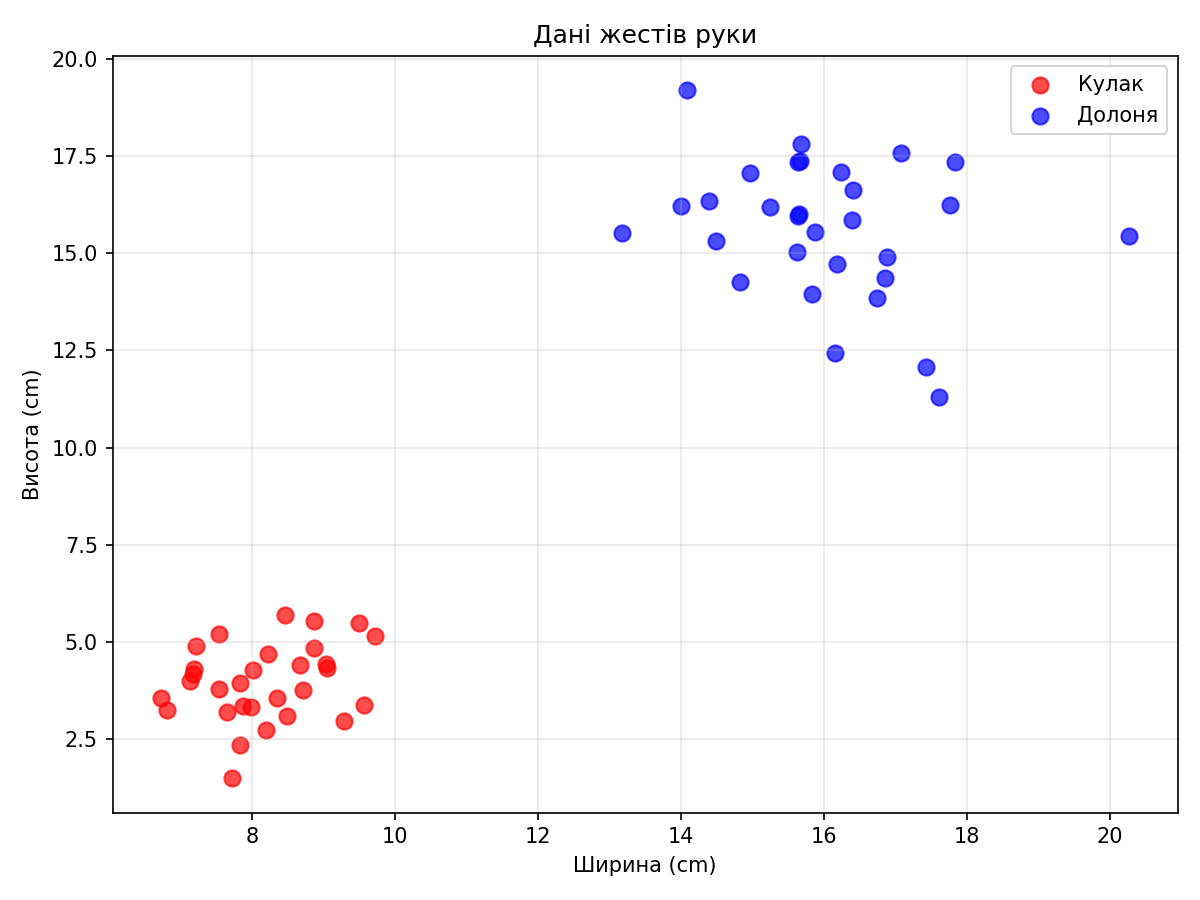

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(fist_w, fist_h, c='red', label='Кулак', s=60, alpha=0.7)
ax.scatter(palm_w, palm_h, c='blue', label='Долоня', s=60, alpha=0.7)
ax.set_xlabel('Ширина (cm)')
ax.set_ylabel('Висота (cm)')
ax.set_title('Дані жестів руки')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('data_visualization.png', dpi=150)
plt.close()
display(Image('data_visualization.png'))


## 3. k-NN класифікатор



Експериментальна перевірка на окремих тестових даних
[2 класи] k=1: точність = 100.0%
[2 класи] k=3: точність = 100.0%
[2 класи] k=5: точність = 100.0%
[2 класи] k=7: точність = 100.0%
[3 класи] k=1: точність = 96.7%
[3 класи] k=3: точність = 97.8%
[3 класи] k=5: точність = 97.8%
[3 класи] k=7: точність = 97.8%


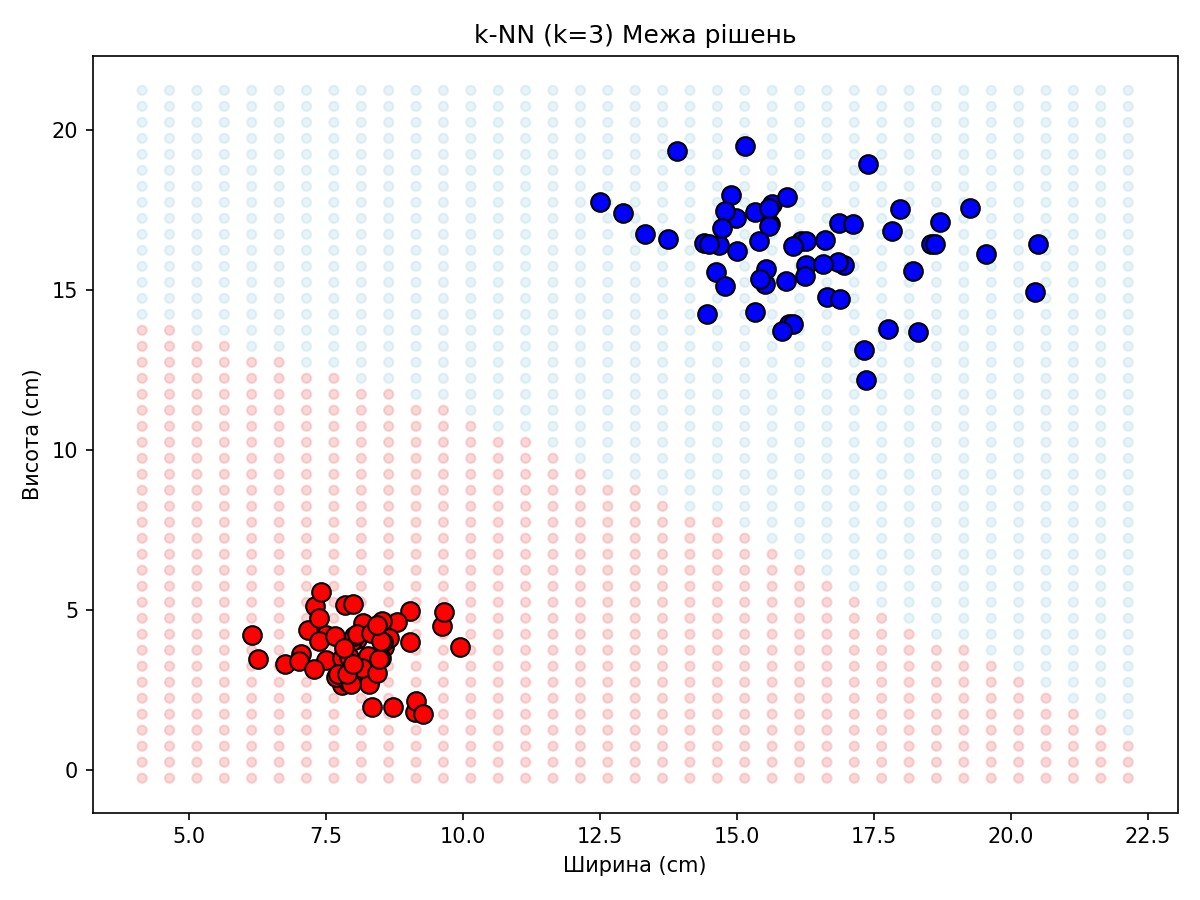

In [12]:
import math
def euclidean_dist(p1, p2):
    return math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)
def knn_predict(train_X, train_y, point, k=3):
    distances = sorted([(euclidean_dist(point, p), train_y[i]) for i, p in enumerate(train_X)])
    votes = {}
    for _, label in distances[:k]:
        votes[label] = votes.get(label, 0) + 1
    return max(votes, key=votes.get)

# Independent Data Generation for Evaluation
eval_rng = RNG(999) 
def generate_eval_class(n, cw, ch, sw, sh):
    return [(eval_rng.gauss(cw, sw), eval_rng.gauss(ch, sh)) for _ in range(n)]

# Scenario 1: 2 Classes
train_fist_2 = generate_eval_class(60, 8, 4, 0.8, 0.9)
train_palm_2 = generate_eval_class(60, 16, 16, 1.5, 1.8)
train_X_2 = train_fist_2 + train_palm_2
train_y_2 = [0]*len(train_fist_2) + [1]*len(train_palm_2)

test_fist_2 = generate_eval_class(30, 8, 4, 0.8, 0.9)
test_palm_2 = generate_eval_class(30, 16, 16, 1.5, 1.8)
test_X_2 = test_fist_2 + test_palm_2
test_y_2 = [0]*len(test_fist_2) + [1]*len(test_palm_2)

print("\n" + "=" * 60)
print("Експериментальна перевірка на окремих тестових даних")
print("=" * 60)

for k in [1, 3, 5, 7]:
    correct = sum(1 for i, p in enumerate(test_X_2) if knn_predict(train_X_2, train_y_2, p, k) == test_y_2[i])
    print(f"[2 класи] k={k}: точність = {correct/len(test_y_2)*100:.1f}%")

# Scenario 2: 3 Classes (+ Victory)
train_victory = generate_eval_class(60, 10, 12, 1.5, 2.0)
test_victory = generate_eval_class(30, 10, 12, 1.5, 2.0)

train_X_3 = train_X_2 + train_victory
train_y_3 = train_y_2 + [2]*len(train_victory)

test_X_3 = test_X_2 + test_victory
test_y_3 = test_y_2 + [2]*len(test_victory)

for k in [1, 3, 5, 7]:
    correct = sum(1 for i, p in enumerate(test_X_3) if knn_predict(train_X_3, train_y_3, p, k) == test_y_3[i])
    print(f"[3 класи] k={k}: точність = {correct/len(test_y_3)*100:.1f}%")

fig, ax = plt.subplots(figsize=(8, 6))
plot_X = train_X_2
plot_y = train_y_2
x_min, x_max = min(p[0] for p in plot_X) - 2, max(p[0] for p in plot_X) + 2
y_min, y_max = min(p[1] for p in plot_X) - 2, max(p[1] for p in plot_X) + 2
xx = x_min
grid_x, grid_y, grid_c = [], [], []
while xx <= x_max:
    yy = y_min
    while yy <= y_max:
        pred = knn_predict(plot_X, plot_y, (xx, yy), 3)
        grid_x.append(xx); grid_y.append(yy); grid_c.append('lightcoral' if pred == 0 else 'lightblue')
        yy += 0.5
    xx += 0.5
ax.scatter(grid_x, grid_y, c=grid_c, s=20, alpha=0.3)
for point, label in zip(plot_X, plot_y):
    ax.scatter(point[0], point[1], c='red' if label == 0 else 'blue', s=80, edgecolors='black')
ax.set_xlabel('Ширина (cm)'); ax.set_ylabel('Висота (cm)'); ax.set_title('k-NN (k=3) Межа рішень')
plt.tight_layout()
plt.savefig('knn_boundary.png', dpi=150)
plt.close()
display(Image('knn_boundary.png'))


## 4. Проблема: Знак перемоги


Згенеровано 30 зразків: Знак перемоги


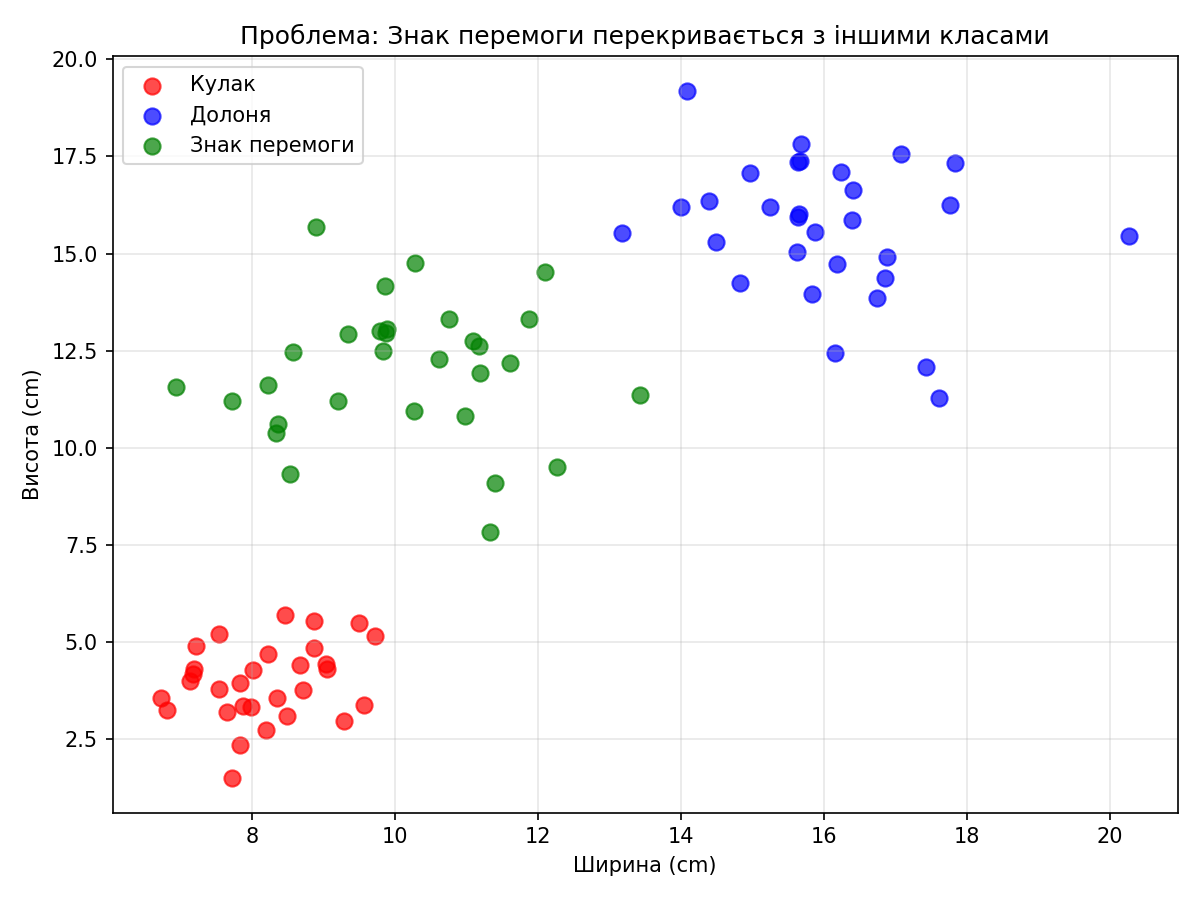

Знак перемоги має проміжні розміри - це демонструє обмеження ознак ширина/висота


In [13]:
rng3 = RNG(777)
victory_data = [(rng3.gauss(10, 1.5), rng3.gauss(12, 2.0)) for _ in range(30)]
print(f"Згенеровано {len(victory_data)} зразків: Знак перемоги")

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(fist_w, fist_h, c='red', label='Кулак', s=60, alpha=0.7)
ax.scatter(palm_w, palm_h, c='blue', label='Долоня', s=60, alpha=0.7)
ax.scatter([p[0] for p in victory_data], [p[1] for p in victory_data], c='green', label='Знак перемоги', s=60, alpha=0.7)
ax.set_xlabel('Ширина (cm)'); ax.set_ylabel('Висота (cm)')
ax.set_title('Проблема: Знак перемоги перекривається з іншими класами')
ax.legend(); ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('victory_problem.png', dpi=150)
plt.close()
display(Image('victory_problem.png'))
print("Знак перемоги має проміжні розміри - це демонструє обмеження ознак ширина/висота")


## 5. k-means кластеризація


k | WCSS
---|---
2 | 196.0
3 | 131.4
5 | 96.6


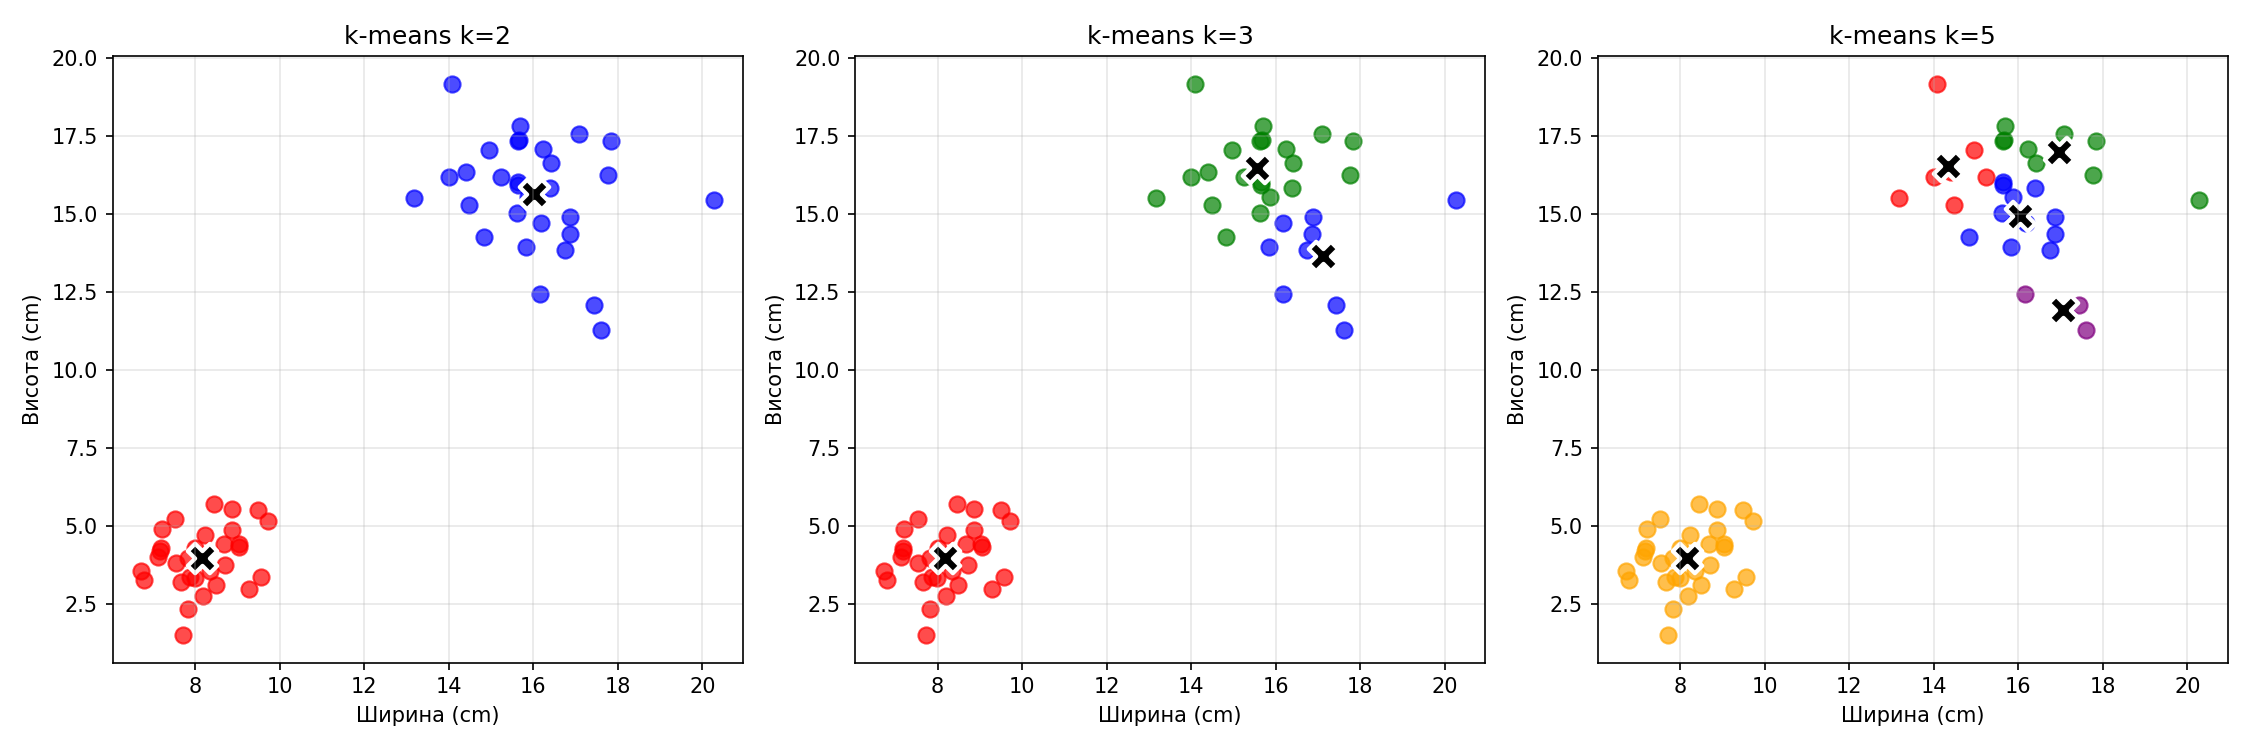

In [14]:
def kmeans(data, k, max_iter=100):
    rng_km = RNG(42 + k)
    indices = list(range(len(data)))
    for i in range(len(indices)-1, 0, -1):
        j = int(rng_km.random() * (i+1))
        indices[i], indices[j] = indices[j], indices[i]
    centroids = [data[i] for i in indices[:k]]
    for _ in range(max_iter):
        clusters = [[] for _ in range(k)]
        labels = []
        for point in data:
            nearest = min(range(k), key=lambda i: euclidean_dist(point, centroids[i]))
            labels.append(nearest)
            clusters[nearest].append(point)
        new_c = []
        for i, cl in enumerate(clusters):
            new_c.append((sum(p[0] for p in cl)/len(cl), sum(p[1] for p in cl)/len(cl)) if cl else centroids[i])
        if new_c == centroids: break
        centroids = new_c
    return labels, centroids

def calculate_wcss(data, labels, centroids):
    wcss = 0
    for i, point in enumerate(data):
        c = centroids[labels[i]]
        wcss += (point[0]-c[0])**2 + (point[1]-c[1])**2
    return wcss

colors = ['red', 'blue', 'green', 'orange', 'purple']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
print("k | WCSS")
print("---|---")
for idx, k in enumerate([2, 3, 5]):
    labels, centroids = kmeans(X, k)
    wcss = calculate_wcss(X, labels, centroids)
    print(f"{k} | {wcss:.1f}")
    
    ax = axes[idx]
    for i, point in enumerate(X):
        ax.scatter(point[0], point[1], c=colors[labels[i]], s=60, alpha=0.7)
    for c in centroids:
        ax.scatter(c[0], c[1], c='black', marker='X', s=200, edgecolors='white', linewidths=2)
    ax.set_xlabel('Ширина (cm)'); ax.set_ylabel('Висота (cm)'); ax.set_title(f'k-means k={k}')
    ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('kmeans_results.png', dpi=150)
plt.close()
display(Image('kmeans_results.png'))
